In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

In [2]:
sns.set()

def save_fig(filename):
    plt.tight_layout(pad=0.5, w_pad=1.0, h_pad=1.0)
    save_path = os.path.join("..", "images", filename)
    plt.savefig(save_path, dpi = 300, bbox_inches="tight")

## Question 1

In [3]:
n_neurons = 4
n_samples = 50
n_xrange = 360
X = np.arange(0.0, 2 * np.pi, 2 * np.pi / n_xrange)
a = 40

def fi(i_neuron):
    return np.pi / 4 + 2 * np.pi * i_neuron / n_neurons

def gaussian():
    std = 10
    ni = np.random.normal(0, 1)
    return std * ni

def poisson(f_i):
    ri = np.random.poisson(f_i)
    return ri

def sim_neuron(i_neuron, noise=None):
    return [
        a * max(np.cos(x - fi(i_neuron)), 0)
        for x in X
    ]

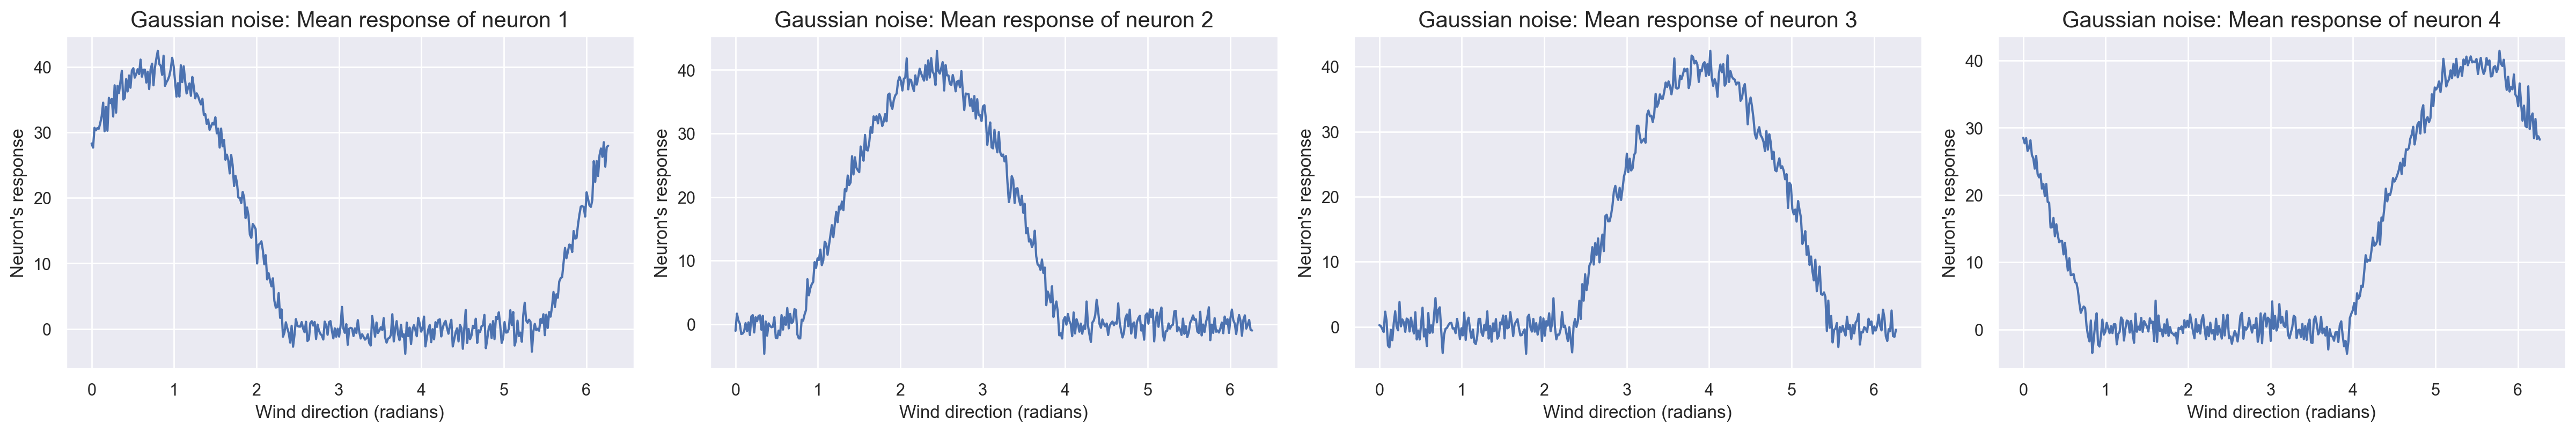

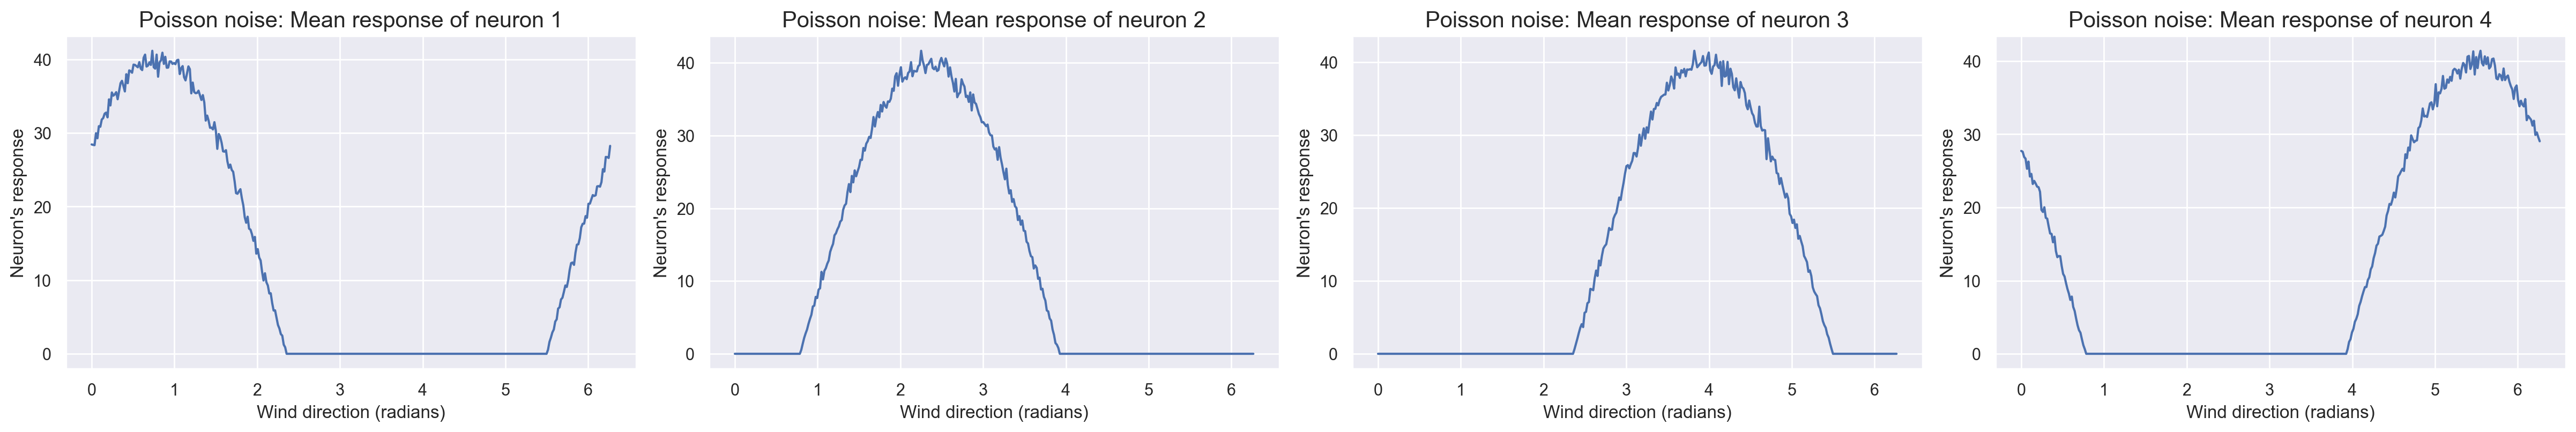

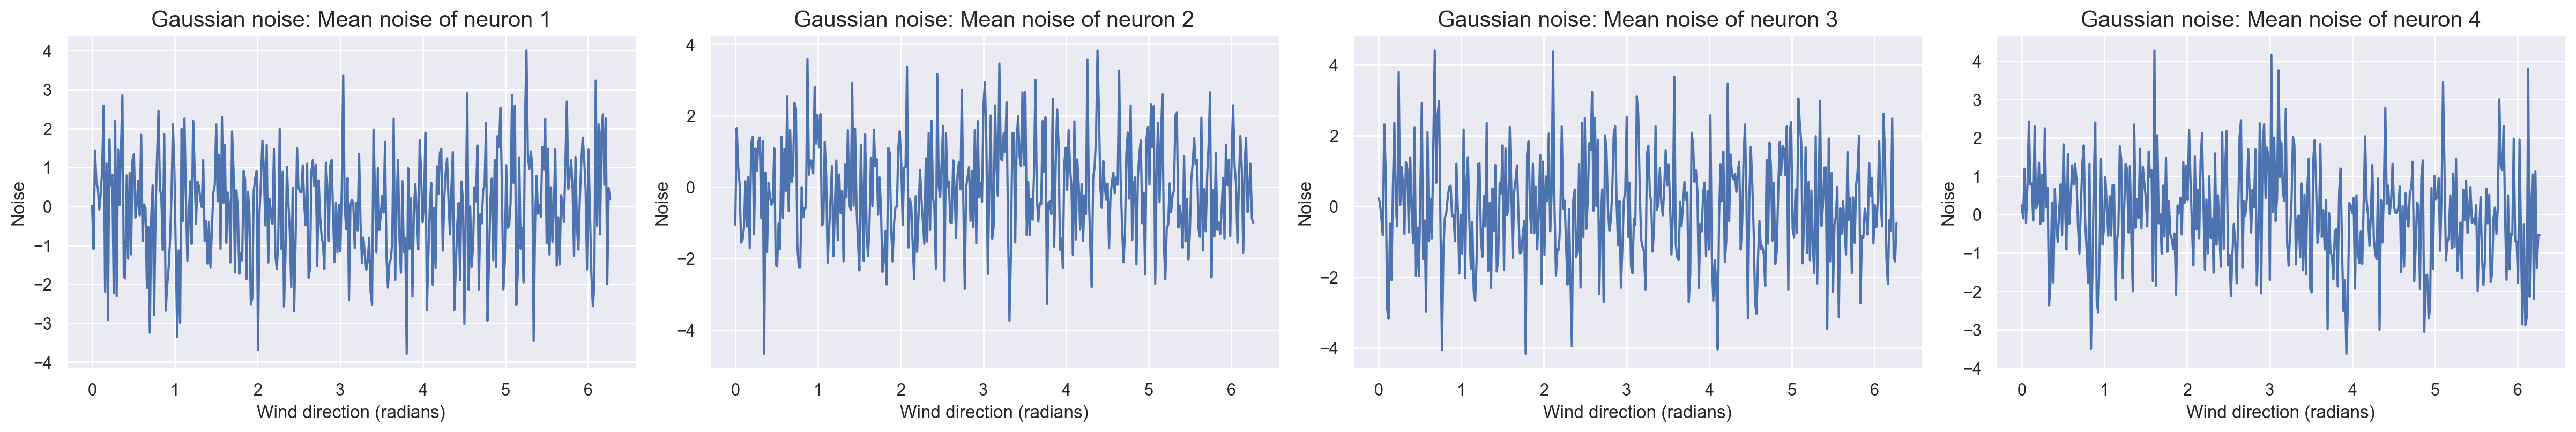

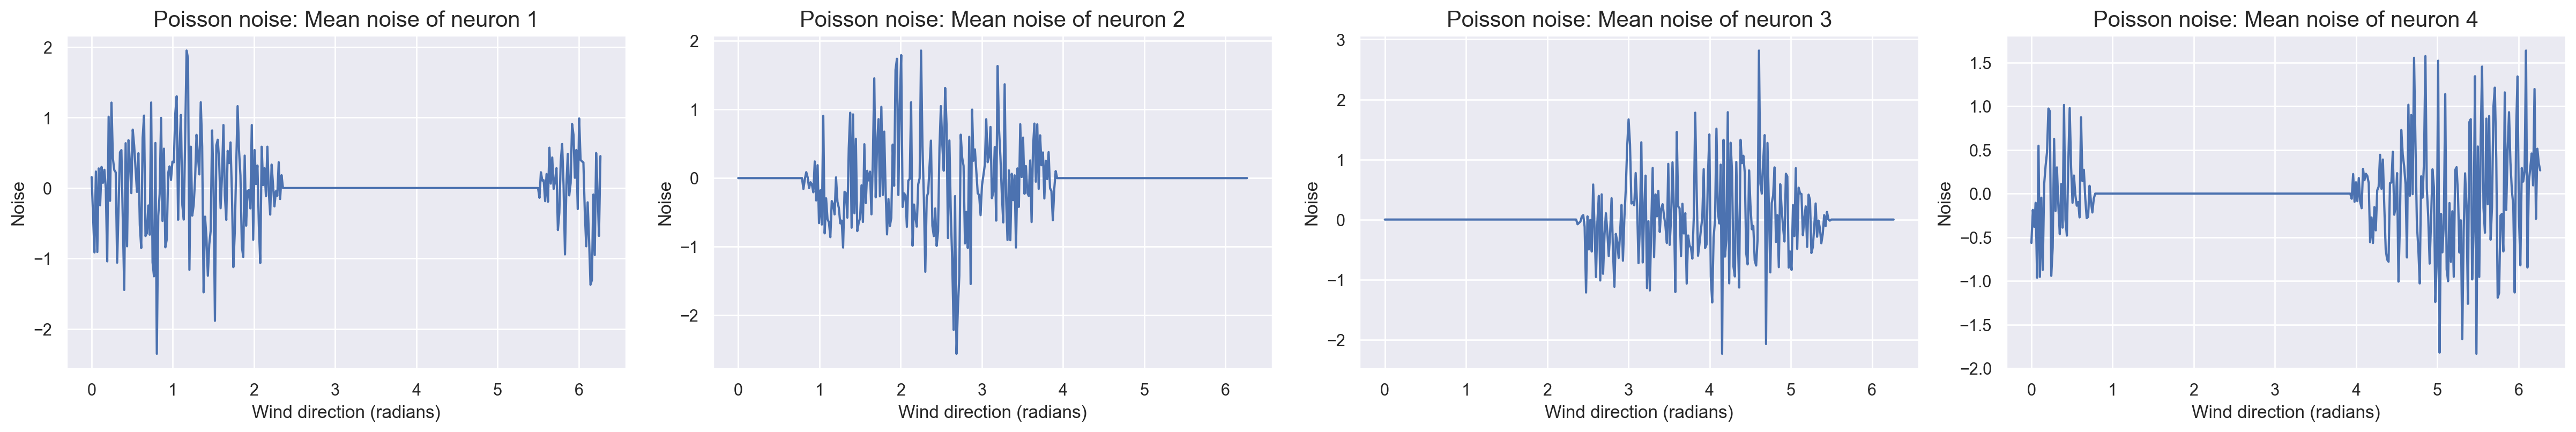

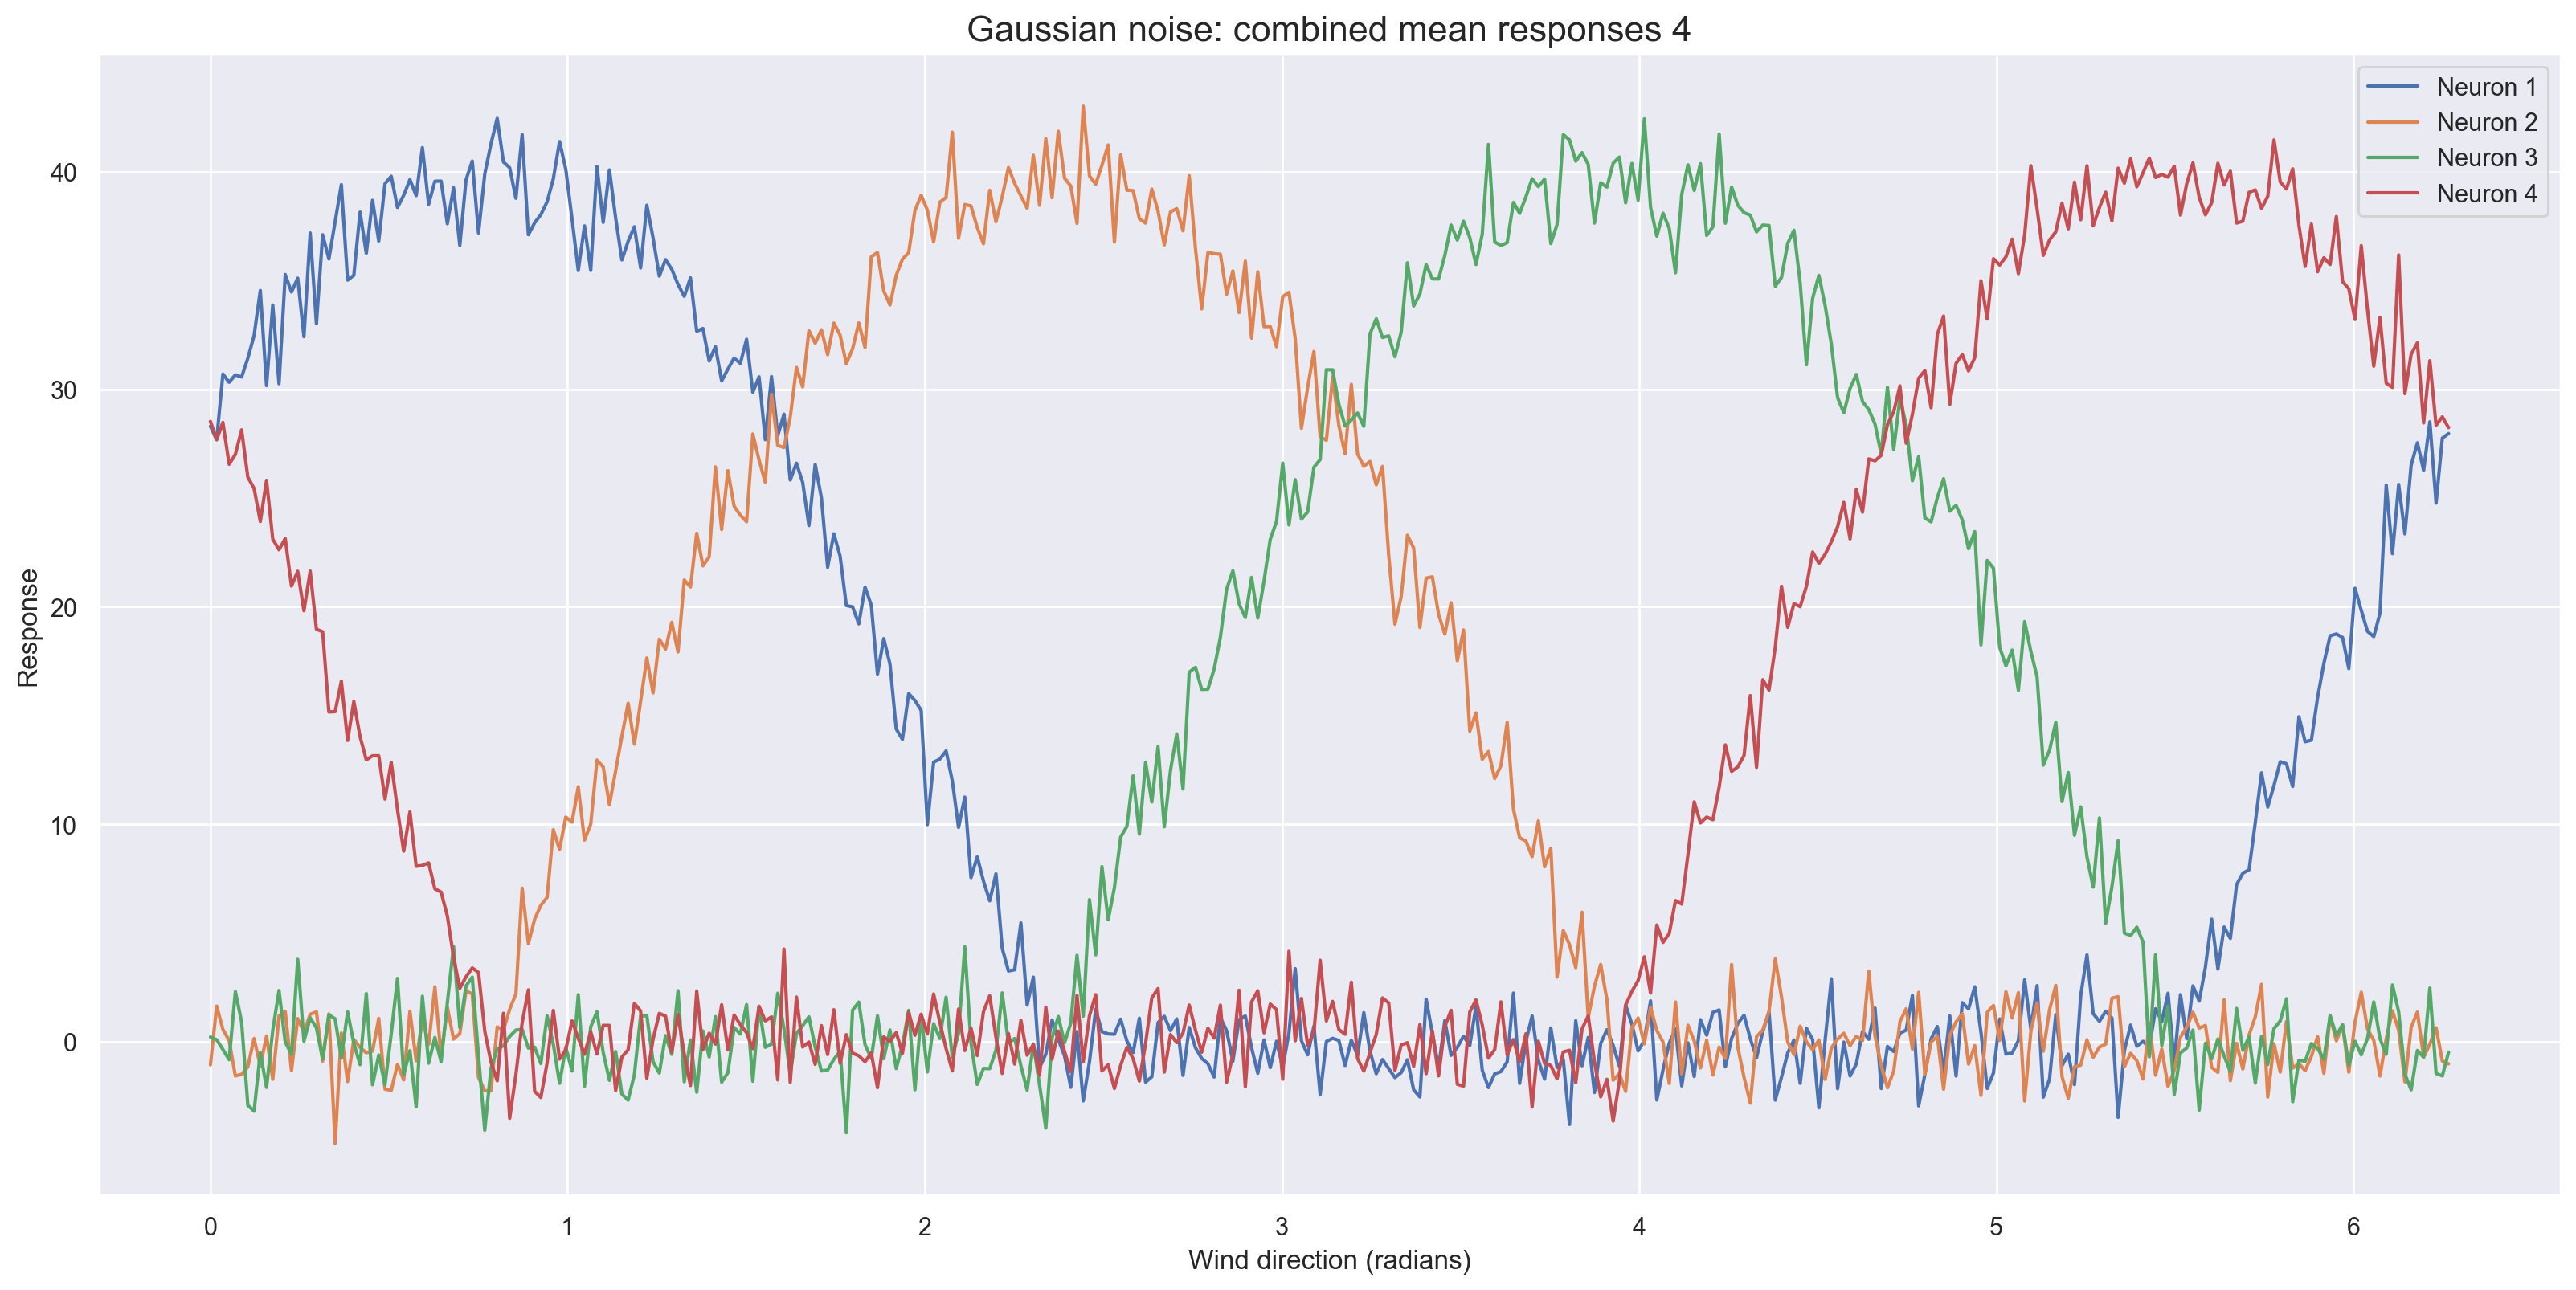

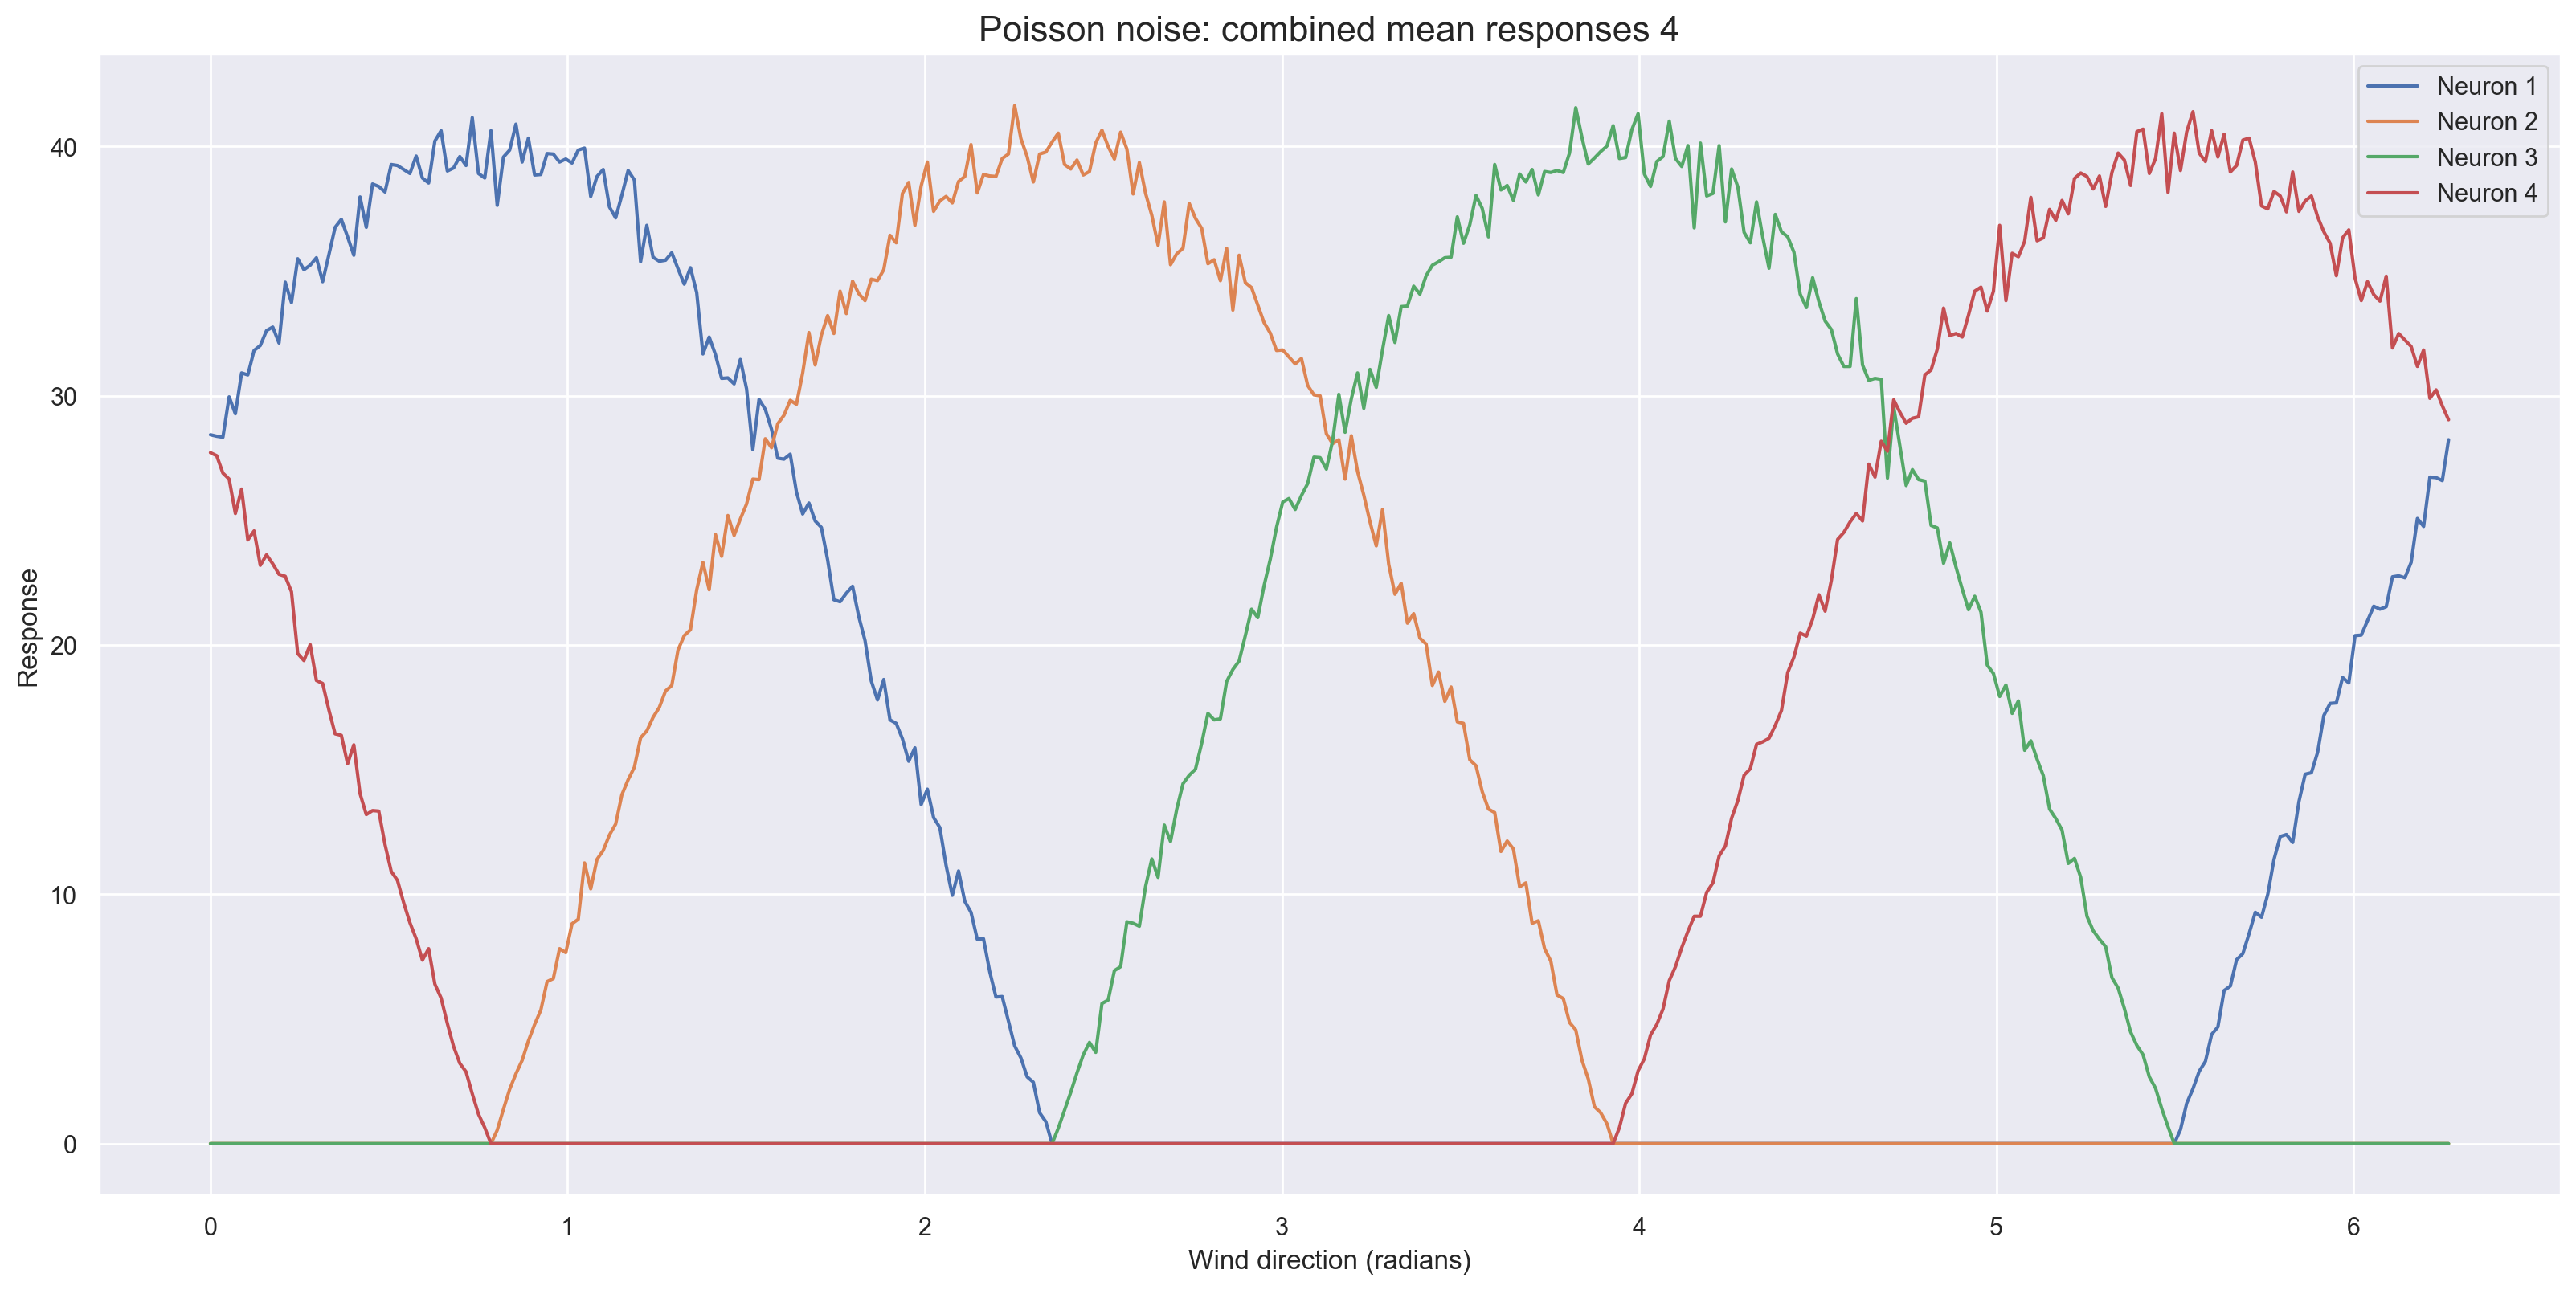

In [4]:
# 4 x 360
Y_real = [
    [
        a * max(np.cos(x - fi(i_neuron)), 0)
        for x in X
    ]
    for i_neuron in range(n_neurons)
]

# 4 x 360 x 100
Y_gaussian_noise = [
    [
        [
            gaussian()
            for i_sample in range(n_samples)
        ]
        for f_i in neuron
    ]
    for neuron in Y_real
]

# 4 x 360
Y_gaussian_noise_mean = [
    [
        np.mean(degree)
        for degree in neuron
    ]
    for neuron in Y_gaussian_noise
]

# 4 x 360 x 100
Y_gaussian_perturbed = [
    [
        [
             noise + Y_real[i_neuron][i_degree]
            for noise in degree
        ]
        for i_degree, degree in enumerate(neuron)
    ]
    for i_neuron, neuron in enumerate(Y_gaussian_noise)
]

# 4 x 360
Y_gaussian_mean = [
    [
        np.mean(degree)
        for degree in neuron
    ]
    for neuron in Y_gaussian_perturbed
]

# 4 x 360 x 100
Y_poisson_noise = [
    [
        [
            poisson(f_i) - f_i
            for i_sample in range(n_samples)
        ]
        for f_i in neuron
    ]
    for neuron in Y_real
]

# 4 x 360
Y_poisson_noise_mean = [
    [
        np.mean(degree)
        for degree in neuron
    ]
    for neuron in Y_poisson_noise
]

# 4 x 360 x 100
Y_poisson_perturbed = [
    [
        [
             noise + Y_real[i_neuron][i_degree]
            for noise in degree
        ]
        for i_degree, degree in enumerate(neuron)
    ]
    for i_neuron, neuron in enumerate(Y_poisson_noise)
]

# 4 x 360
Y_poisson_mean = [
    [
        np.mean(degree)
        for degree in neuron
    ]
    for neuron in Y_poisson_perturbed
]


# Plots
plt.figure(figsize=(24, 4), dpi=200)

for i_neuron in range(n_neurons):
    ax = plt.subplot(1, 4, i_neuron + 1)
    sns.lineplot(X, Y_gaussian_mean[i_neuron], ax=ax)
    plt.title("Gaussian noise: Mean response of neuron %d" % (i_neuron + 1), fontsize=15)
    plt.xlabel("Wind direction (radians)")
    plt.ylabel("Neuron's response")
save_fig("gaussian_response.png")
plt.show()

plt.figure(figsize=(24, 4), dpi=200)

for i_neuron in range(n_neurons):
    ax = plt.subplot(1, 4, i_neuron + 1)
    sns.lineplot(X, Y_poisson_mean[i_neuron], ax=ax)
    plt.title("Poisson noise: Mean response of neuron %d" % (i_neuron + 1), fontsize=15)
    plt.xlabel("Wind direction (radians)")
    plt.ylabel("Neuron's response")
save_fig("poisson_response.png")
plt.show()

plt.figure(figsize=(24, 4), dpi=200)

for i_neuron in range(n_neurons):
    ax = plt.subplot(1, 4, i_neuron + 1)
    sns.lineplot(X, Y_gaussian_noise_mean[i_neuron], ax=ax)
    plt.title("Gaussian noise: Mean noise of neuron %d" % (i_neuron + 1), fontsize=15)
    plt.xlabel("Wind direction (radians)")
    plt.ylabel("Noise")
save_fig("gaussian_noise.png")
plt.show()

plt.figure(figsize=(24, 4), dpi=200)

for i_neuron in range(n_neurons):
    ax = plt.subplot(1, 4, i_neuron + 1)
    sns.lineplot(X, Y_poisson_noise_mean[i_neuron], ax=ax)
    plt.title("Poisson noise: Mean noise of neuron %d" % (i_neuron + 1), fontsize=15)
    plt.xlabel("Wind direction (radians)")
    plt.ylabel("Noise")
save_fig("poisson_noise.png")
plt.show()

plt.figure(figsize=(16, 8), dpi=200)

for i_neuron in range(n_neurons):
    sns.lineplot(X, Y_gaussian_mean[i_neuron])
plt.title("Gaussian noise: combined mean responses %d" % (i_neuron + 1), fontsize=16)
plt.legend(["Neuron 1", "Neuron 2", "Neuron 3", "Neuron 4"])
plt.xlabel("Wind direction (radians)")
plt.ylabel("Response")
save_fig("gaussian_combined.png")
plt.show()

plt.figure(figsize=(16, 8), dpi=200)

for i_neuron in range(n_neurons):
    sns.lineplot(X, Y_poisson_mean[i_neuron])
plt.title("Poisson noise: combined mean responses %d" % (i_neuron + 1), fontsize=16)
plt.legend(["Neuron 1", "Neuron 2", "Neuron 3", "Neuron 4"])
plt.xlabel("Wind direction (radians)")
plt.ylabel("Response")
save_fig("poisson_combined.png")
plt.show()

## Question 2

In [5]:
def cart2pol(x, y):
    magnitude = np.sqrt(x**2 + y**2)
    angle = np.arctan2(y, x)
    return(magnitude, angle)

def pol2cart(magnitude, angle):
    x = magnitude * np.cos(angle)
    y = magnitude * np.sin(angle)
    return(x, y)

# Calculates the mean of the angles
# predicted by the population of neurons
def mean_wind_direction(Ys):
    angles = []
    for degree in Ys:
        angle_x = 0
        angle_y = 0
        for i_neuron in range(n_neurons):
            x, y = pol2cart(degree[i_neuron], fi(i_neuron))
            angle_x += x
            angle_y += y
        magnitude, angle = cart2pol(angle_x, angle_y)
        if angle < 0:
            angle += 2 * np.pi
        angles.append(angle)
    return angles

def polar_plot_df(df, height=8, hue=None):
    g = sns.FacetGrid(
        df,
        subplot_kws=dict(projection='polar'),
        hue=hue,
        height=height,
        despine=False,
    )
    g.map(sns.scatterplot, "X", "Y")
    return g

def polar_plot(X, Y, height=6, hue=None):
    df = pd.DataFrame([X, Y], index=["X", "Y"]).T
    return polar_plot_df(df, height, hue)

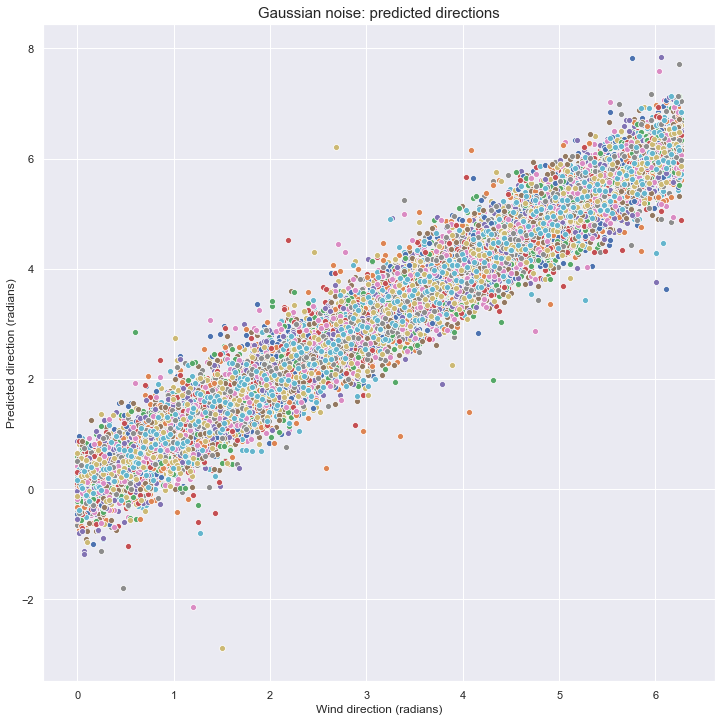

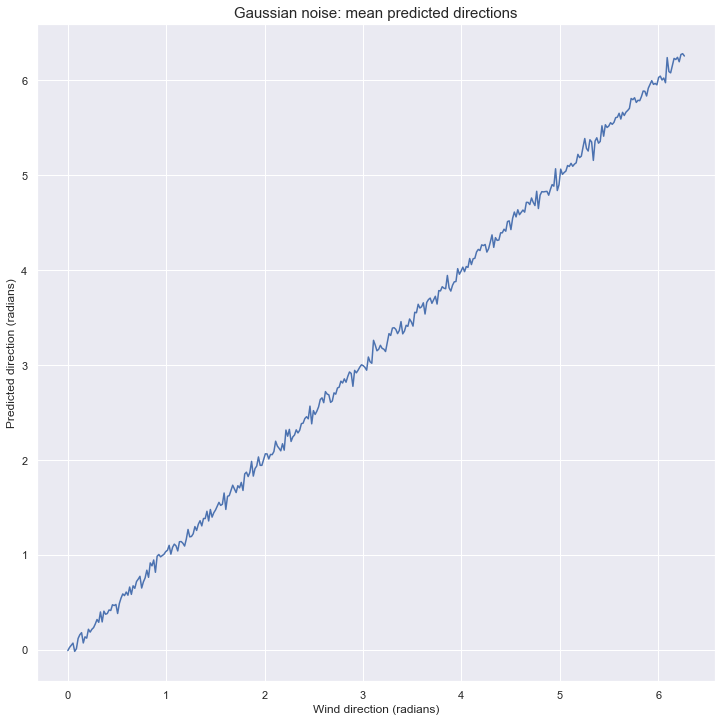

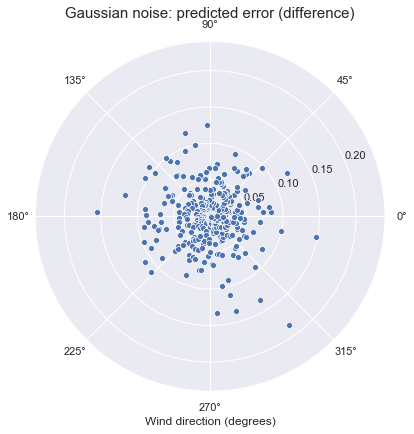

In [27]:
# 100 x 360
Y_gaussian_pred = []

for trial in np.rollaxis(np.array(Y_gaussian_perturbed), 2):
    Y_flipped = [ list(flip) for flip in np.rollaxis(np.array(trial), 1) ]
    Y_gaussian_pred.append(mean_wind_direction(Y_flipped))

for trial in Y_gaussian_pred:
    for i in range(90):
        if trial[i] > np.pi:
            trial[i] = trial[i] - 2 * np.pi
        if trial[len(X) - i - 1] < 1/2 * np.pi:
            trial[len(X) - i - 1] = trial[len(X) - i - 1] + 2 * np.pi

plt.figure(figsize=(10, 10))
for trial in Y_gaussian_pred:
    sns.scatterplot(X, trial)
plt.title("Gaussian noise: predicted directions", fontsize=15)
plt.xlabel("Wind direction (radians)")
plt.ylabel("Predicted direction (radians)")
save_fig("gaussian_variability.png")
plt.show()    

# 360 x 100
Y_gaussian_pred = [
    [
        pol2cart(1, pred)
        for pred in flip
    ]
    for real_angle, flip in enumerate(np.rollaxis(np.array(Y_gaussian_pred), 1))
]

# 360
Y_gaussian_pred_mean = [
    cart2pol(np.mean([ x[0] for x in degree ]), np.mean([ y[1] for y in degree ]))[1]
    for degree in Y_gaussian_pred
]

# < 0
Y_gaussian_pred_mean = [
    degree + 2 * np.pi if degree < 0 else degree
    for degree in Y_gaussian_pred_mean
]

for i in range(45):
    if Y_gaussian_pred_mean[i] > np.pi:
        Y_gaussian_pred_mean[i] = Y_gaussian_pred_mean[i] - 2 * np.pi
    if Y_gaussian_pred_mean[len(X) - i - 1] < np.pi:
        Y_gaussian_pred_mean[len(X) - i - 1] = Y_gaussian_pred_mean[len(X) - i - 1] + 2 * np.pi

plt.figure(figsize=(10, 10))
sns.lineplot(X, Y_gaussian_pred_mean)
plt.title("Gaussian noise: mean predicted directions", fontsize=15)
plt.xlabel("Wind direction (radians)")
plt.ylabel("Predicted direction (radians)")
save_fig("gaussian_predicted.png")
plt.show()

# Decode aggregated Y
angles = Y_gaussian_pred_mean

# Plot
angle_err = []
for i, angle in enumerate(angles):
    err = np.abs(angle - X[i])
    angle_err.append(err)

polar_plot(X, angle_err)
plt.title("Gaussian noise: predicted error (difference)", fontsize=15)
plt.xlabel("Wind direction (degrees)")
plt.ylabel("")
save_fig("gaussian_polar.png")
plt.show()

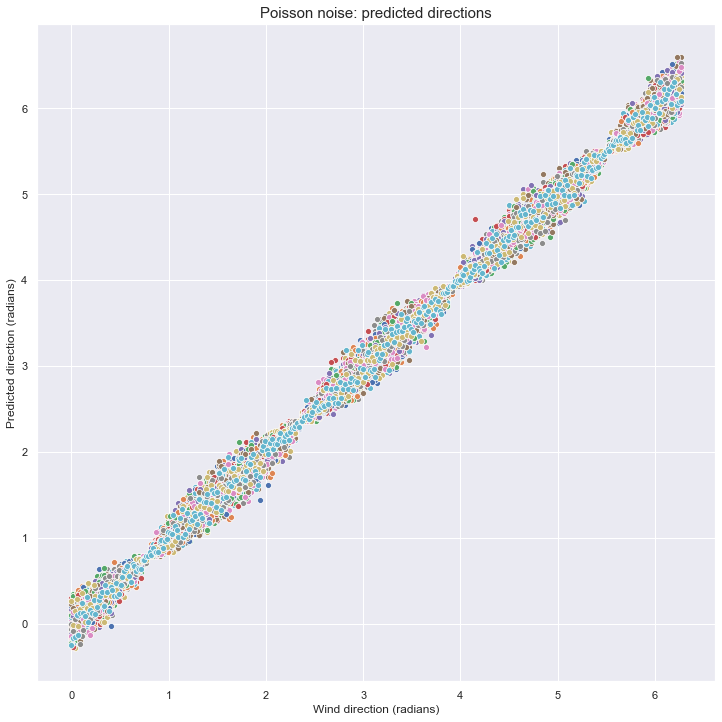

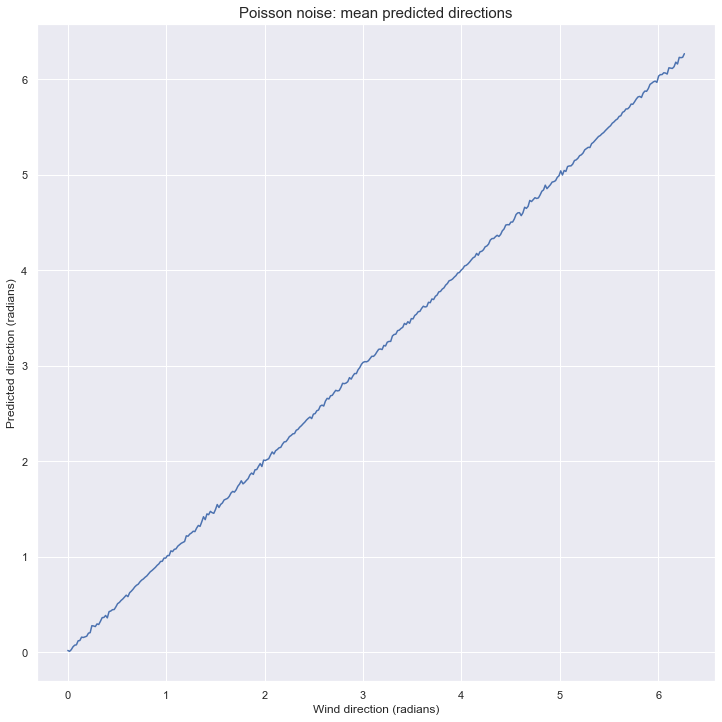

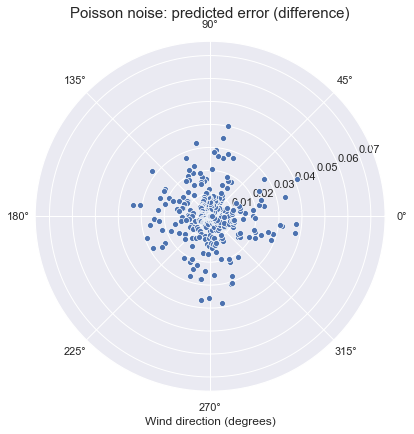

In [23]:
# 100 x 360
Y_poisson_pred = []

for trial in np.rollaxis(np.array(Y_poisson_perturbed), 2):
    Y_flipped = [ list(flip) for flip in np.rollaxis(np.array(trial), 1) ]
    Y_poisson_pred.append(mean_wind_direction(Y_flipped))

for trial in Y_poisson_pred:
    for i in range(45):
        if trial[i] > np.pi:
            trial[i] = trial[i] - 2 * np.pi
        if trial[len(X) - i - 1] < np.pi:
            trial[len(X) - i - 1] = trial[len(X) - i - 1] + 2 * np.pi
    
plt.figure(figsize=(10, 10))
for trial in Y_poisson_pred:
    sns.scatterplot(X, trial)
plt.title("Poisson noise: predicted directions", fontsize=15)
plt.xlabel("Wind direction (radians)")
plt.ylabel("Predicted direction (radians)")
save_fig("poisson_variability.png")
plt.show()    

# 360 x 100
Y_poisson_pred = [
    [
        pol2cart(1, pred)
        for pred in flip
    ]
    for real_angle, flip in enumerate(np.rollaxis(np.array(Y_poisson_pred), 1))
]

# 360
Y_poisson_pred_mean = [
    cart2pol(np.mean([ x[0] for x in degree ]), np.mean([ y[1] for y in degree ]))[1]
    for degree in Y_poisson_pred
]

# < 0
Y_poisson_pred_mean = [
    degree + 2 * np.pi if degree < 0 else degree
    for degree in Y_poisson_pred_mean
]

for i in range(45):
    if Y_poisson_pred_mean[i] > np.pi:
        Y_poisson_pred_mean[i] = Y_poisson_pred_mean[i] - 2 * np.pi
    if Y_poisson_pred_mean[len(X) - i - 1] < np.pi:
        Y_poisson_pred_mean[len(X) - i - 1] = Y_poisson_pred_mean[len(X) - i - 1] + 2 * np.pi

plt.figure(figsize=(10, 10))
sns.lineplot(X, Y_poisson_pred_mean)
plt.title("Poisson noise: mean predicted directions", fontsize=15)
plt.xlabel("Wind direction (radians)")
plt.ylabel("Predicted direction (radians)")
save_fig("poisson_predicted.png")
plt.show()

# Decode aggregated Y
angles = Y_poisson_pred_mean

# Plot
angle_err = []
for i, angle in enumerate(angles):
    err = min(np.abs(angle - X[i]), np.abs((2 * np.pi - angle) - X[i]))
    angle_err.append(err)

polar_plot(X, angle_err)
plt.title("Poisson noise: predicted error (difference)", fontsize=15)
plt.xlabel("Wind direction (degrees)")
plt.ylabel("")
save_fig("poisson_polar.png")
plt.show()

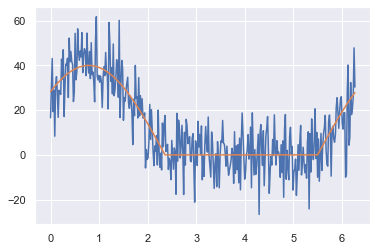

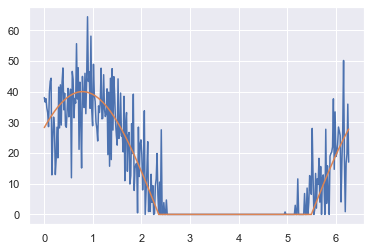

In [28]:
plt.plot(X, [ a * max(np.cos(x - fi(0)), 0) + gaussian() for x in X])
plt.plot(X, [ a * max(np.cos(x - fi(0)), 0) for x in X])
plt.show()
plt.plot(X, [ max(a * np.cos(x - fi(0)) + gaussian(), 0) for x in X])
plt.plot(X, [ a * max(np.cos(x - fi(0)), 0) for x in X])
plt.show()